In [0]:
import pandas as pd
import d2l
from mxnet import gluon, autograd, init, nd
from mxnet.gluon import nn
import random
import matplotlib.pyplot as plt


In [0]:
df = pd.read_csv('../dataCLean.csv', index_col = 0)

In [52]:
df.columns

Index(['SerialNumber', 'City', 'Name', 'longitude', 'latitude', 'FirstOnline',
       'Datetime', 'PM2.5', 'USAQI', 'CO2', 'Temperature', 'RelativeHumidity',
       'Outdoor PM2.5', 'OutdoorUSAQI', 'weekday', 'weekdayName', 'hour',
       'month', 'year', 'dayofmonth', 'tmpc', 'relh', 'drct', 'sped', 'vsby'],
      dtype='object')

In [53]:
drop_columns = ['SerialNumber', 'Name', 'longitude', 'latitude', 'FirstOnline', 'Outdoor PM2.5', 'OutdoorUSAQI']
dfs = df.sort_values('Datetime')
dfn = dfs.drop(drop_columns, axis = 1)
dfn = dfn.dropna()

dfn.head()

,City,Datetime,PM2.5,USAQI,CO2,Temperature,RelativeHumidity,weekday,weekdayName,hour,month,year,dayofmonth,tmpc,relh,drct,sped,vsby
8384,Karachi,2016-10-20 01:00:00,19.0,65,465.0,28.0,71.0,3,Thursday,1,10,2016,20,25.0,83.440,245.0,6.325,2.80
73271,Karachi,2016-10-20 01:00:00,21.0,70,415.0,25.0,80.0,3,Thursday,1,10,2016,20,25.0,83.440,245.0,6.325,2.80
23785,Karachi,2016-10-20 01:00:00,19.0,65,465.0,28.0,71.0,3,Thursday,1,10,2016,20,25.0,83.440,245.0,6.325,2.80
86064,Karachi,2016-10-20 01:00:00,21.0,70,415.0,25.0,80.0,3,Thursday,1,10,2016,20,25.0,83.440,245.0,6.325,2.80
73270,Karachi,2016-10-20 02:00:00,20.0,68,414.0,25.0,80.0,3,Thursday,2,10,2016,20,25.5,83.495,245.0,8.050,2.49


In [67]:
dfk = dfn[dfn.City == 'Karachi'].copy()
dfk.drop('City', inplace = True, axis = 1)
dfk.reset_index(inplace = True, drop = True)
one_hot = pd.get_dummies(dfk.weekdayName)
dfk = dfk.drop(['Datetime', 'weekday', 'weekdayName'], axis = 1)
dfk = (dfk - dfk.mean())/dfk.std()
dfk = dfk.join(one_hot)

dfk.head()

,PM2.5,USAQI,CO2,Temperature,RelativeHumidity,hour,month,year,dayofmonth,tmpc,relh,drct,sped,vsby,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-0.270483,-0.445353,0.517778,0.087300,0.219741,-1.530530,1.601326,-2.536564,0.460941,-0.427032,1.287179,0.480828,-0.482849,-0.875768,0,0,0,0,1,0,0
1,-0.260902,-0.412982,-0.225737,-0.721504,0.687110,-1.530530,1.601326,-2.536564,0.460941,-0.427032,1.287179,0.480828,-0.482849,-0.875768,0,0,0,0,1,0,0
2,-0.270483,-0.445353,0.517778,0.087300,0.219741,-1.530530,1.601326,-2.536564,0.460941,-0.427032,1.287179,0.480828,-0.482849,-0.875768,0,0,0,0,1,0,0
3,-0.260902,-0.412982,-0.225737,-0.721504,0.687110,-1.530530,1.601326,-2.536564,0.460941,-0.427032,1.287179,0.480828,-0.482849,-0.875768,0,0,0,0,1,0,0
4,-0.265693,-0.425931,-0.240608,-0.721504,0.687110,-1.385856,1.601326,-2.536564,0.460941,-0.337387,1.289806,0.480828,-0.162930,-1.328847,0,0,0,0,1,0,0


In [0]:
net = nn.Sequential()

In [0]:
net.add(nn.Dense(120,activation='sigmoid'),
        nn.Dense(40, activation='sigmoid'),
        nn.Dense(1)
)

In [0]:
batch_size=256

In [0]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
#    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)
        # The “take” function will then return the corresponding element based
        # on the indices

In [0]:
def train_test_split(df, l, ratio):
  num = int(len(df) * ratio)
  indices = list(df.index)
#  random.shuffle(indices)
  train = indices[:num]
  test = indices[num:]
  return df.iloc[train], df.iloc[test], l.iloc[train], l.iloc[test]

In [0]:
def eva(net, X, y, l, plot = False):
  y_hat = net(X)
  if plot:
    for i in range(0, min(len(y), 150), 50):
      plt.plot(y[i : i+50].asnumpy())
      plt.plot(y_hat[i : i+50].asnumpy())
      plt.show()
  return l(y_hat, y).mean().asscalar()


epoch number  0
traingin data loss	 0.051053356
testing data loss	 1.0594686
epoch number  1
traingin data loss	 0.04404998
testing data loss	 0.95519644
epoch number  2
traingin data loss	 0.037006993
testing data loss	 0.83603346
epoch number  3
traingin data loss	 0.029457984
testing data loss	 0.7083508
epoch number  4
traingin data loss	 0.022747602
testing data loss	 0.583329
epoch number  5
traingin data loss	 0.017774068
testing data loss	 0.4723568
epoch number  6
traingin data loss	 0.014419846
testing data loss	 0.38555935
epoch number  7
traingin data loss	 0.013159713
testing data loss	 0.32454938
epoch number  8
traingin data loss	 0.013427967
testing data loss	 0.2801482
epoch number  9
traingin data loss	 0.0132194655
testing data loss	 0.24489495
epoch number  10
traingin data loss	 0.012271354
testing data loss	 0.21612647
epoch number  11
traingin data loss	 0.011228676
testing data loss	 0.19225031
epoch number  12
traingin data loss	 0.010315936
testing data loss	 

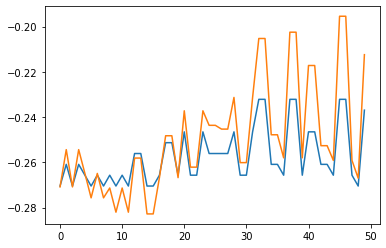

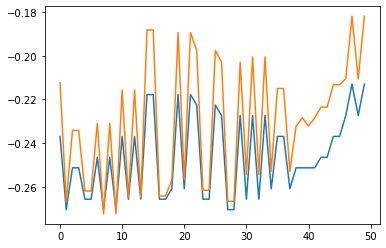

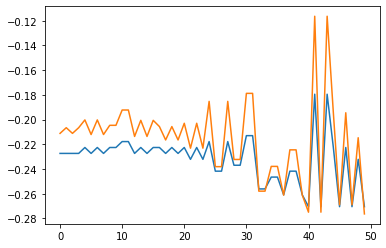

traingin data loss	 0.0019242783


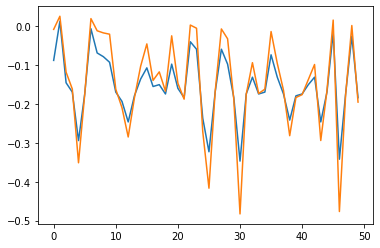

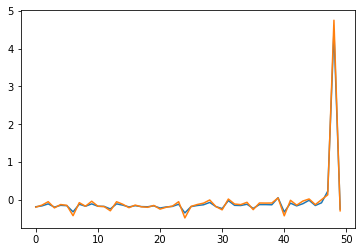

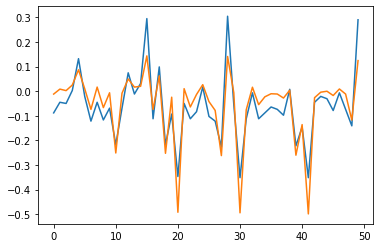

testing data loss	 0.012129603


In [119]:
lr = 0.1
num_epochs = 50

features = dfk.drop('PM2.5', axis = 1)
labels = dfk['PM2.5']

random.seed(6)

tra_f, tes_f, tra_l, tes_l = train_test_split(features, labels, 0.6)
tra_f = nd.array(tra_f.to_numpy())
tes_f = nd.array(tes_f.to_numpy())
tra_l = nd.array(tra_l.to_numpy())
tes_l = nd.array(tes_l.to_numpy())


net.initialize(force_reinit=True,  init=init.Xavier())
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size , tra_f, tra_l):
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        trainer.step(X.shape[0])
    print('epoch number ', epoch)
    print("traingin data loss\t", eva(net, tra_f, tra_l, loss, epoch == num_epochs - 1) )
    print("testing data loss\t", eva(net, tes_f, tes_l, loss, epoch == num_epochs - 1) )    